# Map1D_E
---

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math
import numpy as np

import os

## Basic Usage

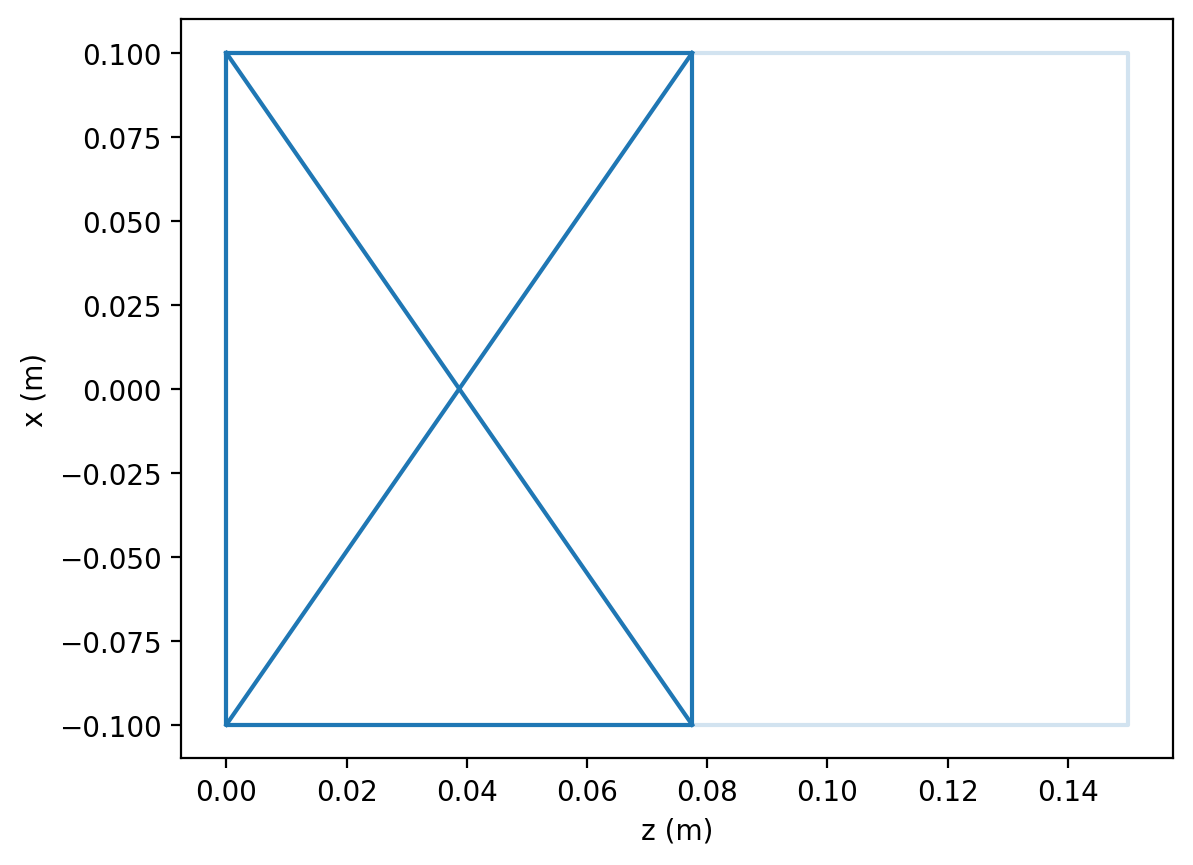

Type:        Map1D_E
String form:
Name: dcgun
Type: Map1D_E
s-entrance: 0 m.
s-exit: 0.15 m.
Length: 0.15
Width: 0.2 m.
File:        ~/GitHub/lume-gpt/src/gpt/maps.py
Docstring:   Defines a 1D [z, Ez] cylindrically symmetric electric field map object

In [2]:
from gpt.maps import Map1D_E
from gpt import GPT

gun = Map1D_E('dcgun', 'fields/dcgun_GHV_1D.gdf')
?gun
gun.plot_floor()

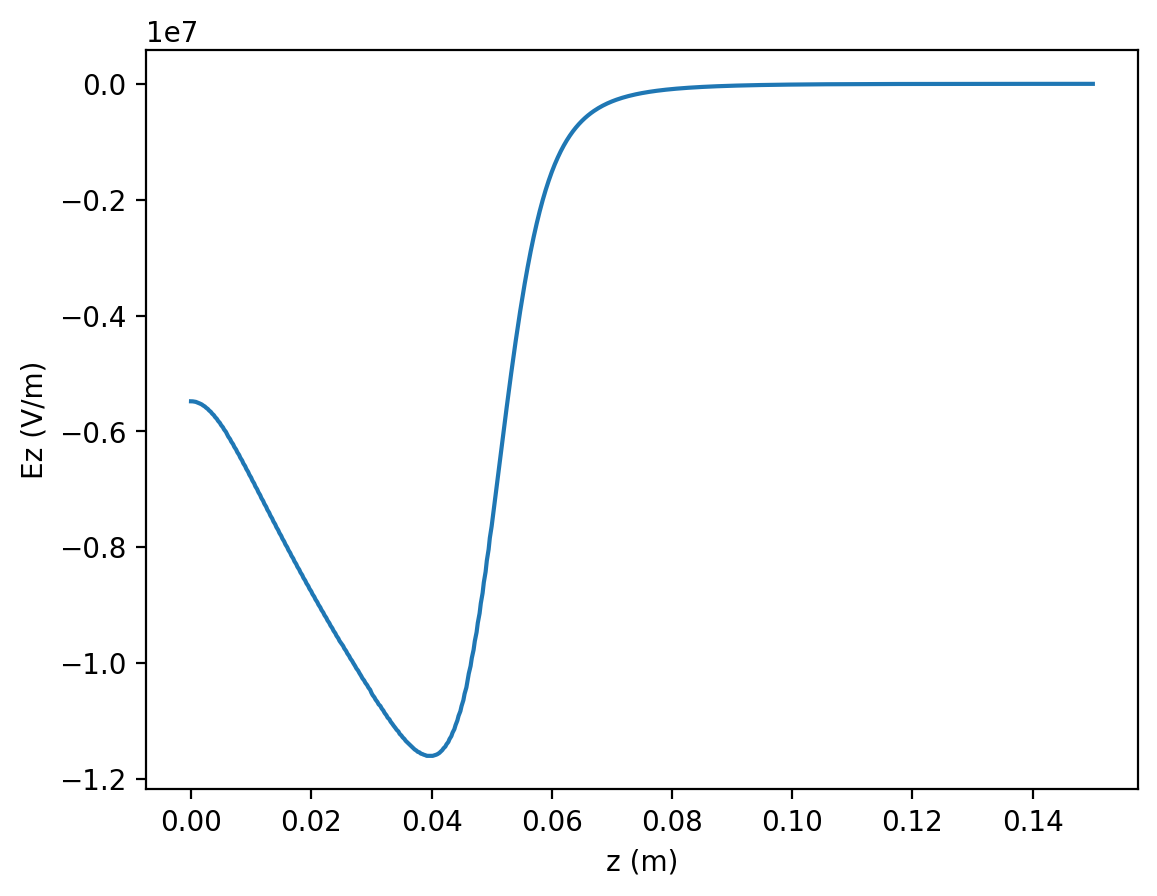

In [3]:
gun.plot_field_profile()

In [4]:
gun.field_integral

np.float64(-500043.32109424996)

## With Lattice Generation

In [5]:
from gpt.lattice import Lattice

In [6]:
lat = Lattice('Map1D_E')
lat.add(Map1D_E('gun', 'fields/dcgun_GHV_1D.gdf', scale=1), ds = 0.0)  

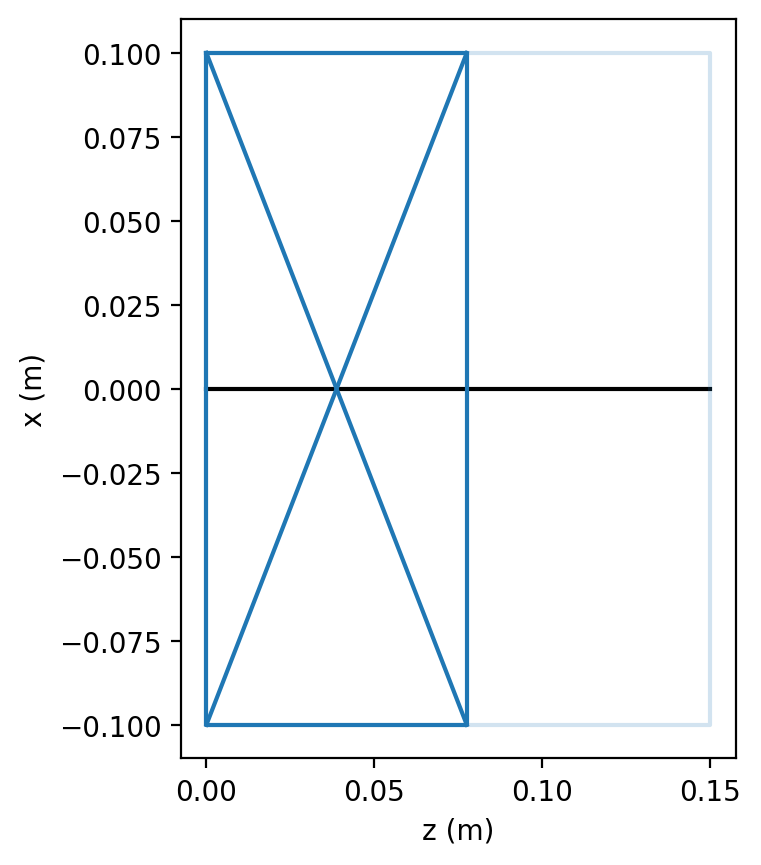

In [7]:
lat.plot_floor()
lat.write_gpt_lines(output_file='gpt.temp.in');

In [8]:
from distgen import Generator

DISTGEN_YAML=f"""
n_particle: 1000
random_type: hammersley
species: electron

total_charge:
  units: nC
  value: 1
start:
  type: cathode
  MTE:
    150 meV
r_dist:
  sigma_xy:
    units: mm
    value: 1
  alpha:
    units: dimensionless
    value: 0.0
  type: rsg
"""

In [9]:
D = Generator(DISTGEN_YAML)
P = D.run()

In [10]:
G = GPT('gpt.temp.in', initial_particles=P)
G.set_variables({'ZSTOP': 1, 'Ntout': 500, 'sol_scale': 2})
G.run()

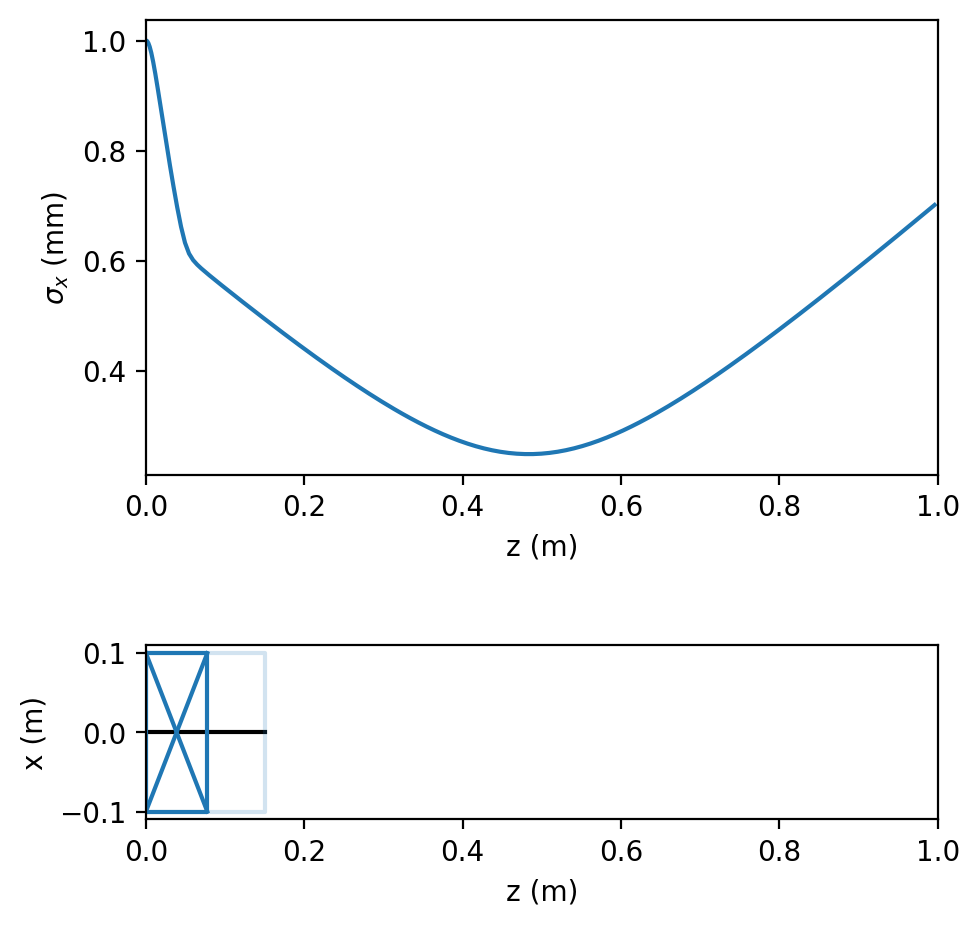

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(5, 5))

axs[0].plot(G.tout_stat('mean_z'), G.tout_stat('sigma_x')*1e3)
axs[0].set_xlabel('z (m)')
axs[0].set_ylabel(r'$\sigma_x$ (mm)')

G.lattice.plot_floor(ax = axs[1])

axs[0].set_xlim([0, 1])
axs[1].set_xlim([0, 1])

plt.tight_layout()


In [12]:
def check_parsing():
    
    lat1 = Lattice('Map1D_E')
    lat1.add(Map1D_E('gun', 'fields/dcgun_GHV_1D.gdf', scale=0.01), ds = 0.5, element_origin='center')  
    lat1.write_gpt_lines(output_file='parse_test.temp.in');

    G = GPT('parse_test.temp.in')
    lat2 = G.lattice

    os.remove('parse_test.temp.in')
    
    # Basic info
    assert lat1['gun']._length==lat2['gun']._length
    assert lat1['gun']._width==lat2['gun']._width
    assert lat1['gun']._height==lat2['gun']._height
    # assert lat1['sol1']._ecs==lat2['sol1']._ecs # FIX LATER
    assert lat1['gun'].name == lat2['gun'].name
    assert lat1['gun']._scale == lat2['gun']._scale
    
check_parsing()

In [13]:
if os.path.exists('gpt.temp.in'):
    os.remove('gpt.temp.in')